Found 43 files belonging to 2 classes.
Using 35 files for training.
Found 43 files belonging to 2 classes.
Using 8 files for validation.
Classes: ['no_tumor', 'tumor']
Training samples: 35
Validation samples: 8


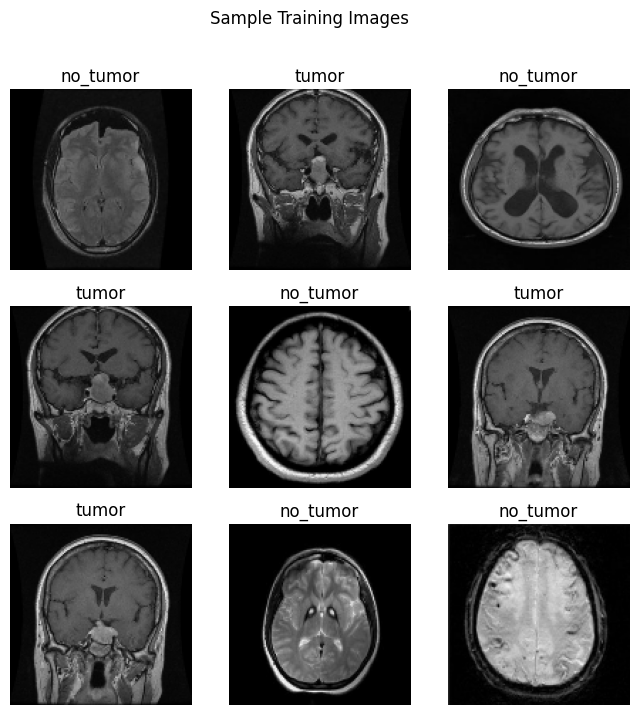

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 316ms/step - accuracy: 0.5150 - loss: 0.7232 - val_accuracy: 0.5000 - val_loss: 0.6579
Epoch 2/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step - accuracy: 0.8491 - loss: 0.3369 - val_accuracy: 0.8750 - val_loss: 0.3379
Epoch 3/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 246ms/step - accuracy: 0.7451 - loss: 0.4701 - val_accuracy: 1.0000 - val_loss: 0.1429
Epoch 4/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.9246 - loss: 0.2014 - val_accuracy: 0.8750 - val_loss: 0.2008
Epoch 5/5
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.9558 - loss: 0.1118 - val_accuracy: 1.0000 - val_loss: 0.0837


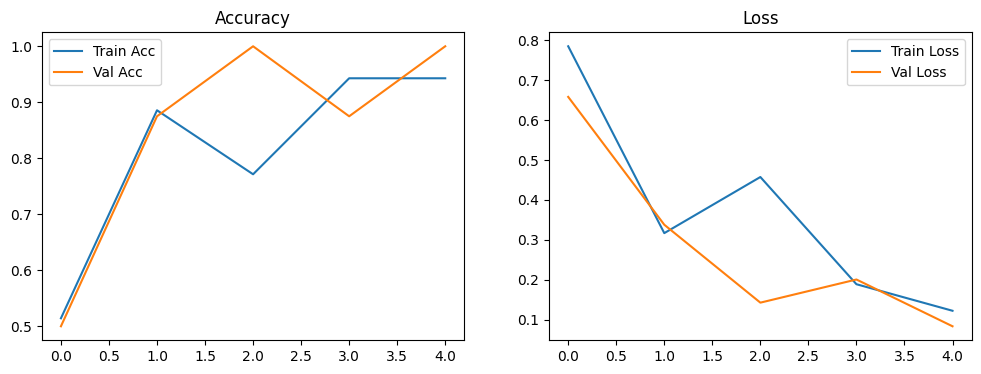

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 8 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

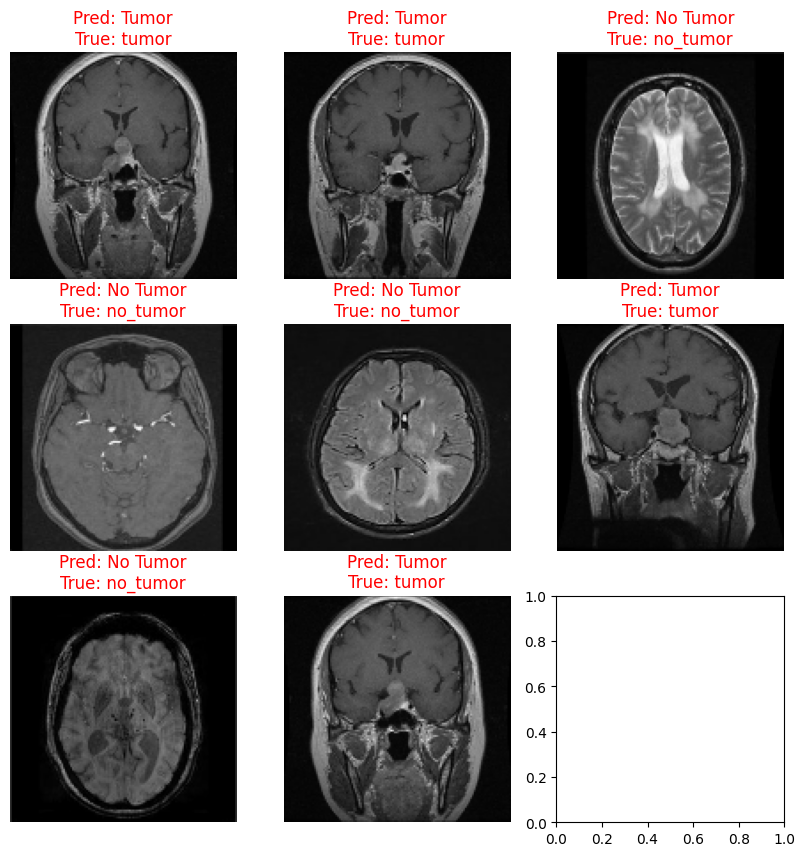

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Dataset path
data_dir = "/content/datasets/training"  # folder with 'tumor' and 'no_tumor' subfolders

img_size = (128, 128)
batch_size = 16

# Train / Validation split
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size)

class_names = train_ds.class_names
print("Classes:", class_names)

# 🔹 Show dataset split counts
train_count = sum([len(batch[1]) for batch in train_ds])
val_count = sum([len(batch[1]) for batch in val_ds])
print(f"Training samples: {train_count}")
print(f"Validation samples: {val_count}")

# 🔹 Display some sample images
plt.figure(figsize=(8, 8))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.suptitle("Sample Training Images")
plt.show()

# Simple CNN
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(128,128,3)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_ds, validation_data=val_ds, epochs=5)

# 🔹 Plot accuracy & loss curves
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss")

plt.show()

# 🔹 Predictions on multiple validation images
plt.figure(figsize=(10,10))
for images, labels in val_ds.take(1):
    preds = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = "Tumor" if preds[i][0] > 0.5 else "No Tumor"
        true_label = class_names[labels[i]]
        plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=("green" if pred_label==true_label else "red"))
        plt.axis("off")
plt.suptitle("Prediction Results")
plt.show()

# 🔹 Confusion matrix and report
y_true = []
y_pred = []
for images, labels in val_ds:
    preds = model.predict(images)
    preds = (preds > 0.5).astype("int32").flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))
